In [3]:
import numpy as np
import pandas as pd
import joblib

DATA_DIR = ''
#---------------------------------------#
#--------------load sMRI----------------#
#---------------------------------------#
ukbb_sMRI = pd.read_csv(DATA_DIR+'')
ukbb_sMRI = ukbb_sMRI.iloc[:, ~ukbb_sMRI.columns.str.contains('-3.0')]
ukbb_sMRI.index = pd.Index(ukbb_sMRI['eid'])
ukbb_sMRI = ukbb_sMRI.drop(columns='eid')
ukbb_sMRI = ukbb_sMRI.dropna()

#brain region label
descr_dict = pd.read_csv(DATA_DIR+'',index_col=False,names=['id','name'])
descr_dict.sort_values('id',inplace=True)
sMRI_name_list = descr_dict['name'].to_list()
sMRI_name = [i.split('\tVolume of grey matter in ')[1] for i in sMRI_name_list]

#---------------------------------------#
#--------------load dMRI----------------#
#---------------------------------------#
ukbb_dMRI = pd.read_csv(DATA_DIR+'')
ukbb_dMRI = ukbb_dMRI.iloc[:,~ukbb_dMRI.columns.str.contains('-3.0')]
ukbb_dMRI = ukbb_dMRI.iloc[:,0:49]

ukbb_dMRI.index = ukbb_dMRI['eid']
ukbb_dMRI = ukbb_dMRI.drop(columns='eid')
ukbb_dMRI = ukbb_dMRI.dropna()

dMRI_name_all = pd.read_csv(DATA_DIR+'', names=['eid','name'])
dMRI_name_all = dMRI_name_all.iloc[0:48,:]
dMRI_name = []
for i in range(dMRI_name_all.shape[0]):
    new_name = dMRI_name_all.iloc[i,1].split('FA in ')[1]
    dMRI_name.append(new_name)

#---------------------------------------#
#--------------load rfMRI---------------#
#---------------------------------------#
# load rfmri_network
TAR_ANA = 'rfMRI_partialcorr_matrix_dim25'
TAR_ITEMS_PER_SUB = 210
n_networks = 21  # n * (n - 1) / 2

f = open(DATA_DIR+'', 'r')
good_comps = np.array([line.strip('\n') for line in f.readlines()])
f.close()

subids, sub_corrs = joblib.load(DATA_DIR+'dump_%s' % TAR_ANA)
ukbb_rfMRI = pd.DataFrame(sub_corrs, index=subids)

#---------------------------------------------#
#---------------accleration data--------------#
#---------------------------------------------#
df_acr = pd.read_csv(DATA_DIR+'')
df_acr = df_acr.dropna()

data_24 = df_acr[['eid','90027-0.0', '90028-0.0','90029-0.0','90030-0.0','90031-0.0','90032-0.0',
                                '90033-0.0','90034-0.0','90035-0.0','90036-0.0','90037-0.0','90038-0.0',
                                '90039-0.0','90040-0.0','90041-0.0','90042-0.0','90043-0.0','90044-0.0',
                                '90045-0.0','90046-0.0','90047-0.0','90048-0.0','90049-0.0','90050-0.0']]
data_24.index = data_24['eid']
data_24 = data_24.drop(columns='eid')
data_24.columns=range(24)
# calibration
df_aci = pd.read_csv(DATA_DIR+'')
df_aci['90002-0.0'] = df_aci['90002-0.0'].fillna(0)
df_aci = df_aci.dropna()
df_aci_new = df_aci.drop(df_aci[df_aci['90002-0.0']>0].index) # data problem indicator
df_aci_new = df_aci_new.drop(df_aci_new[df_aci_new['90015-0.0']==0].index) #good wear time
df_aci_new = df_aci_new.drop(df_aci_new[df_aci_new['90016-0.0']==0].index) # good calibration
df_aci_new = df_aci_new.drop(df_aci_new[df_aci_new['90017-0.0']==0].index) # calibrated on own data
df_aci_new = df_aci_new.drop(df_aci_new[df_aci_new['90180-0.0']!=0].index) # interrupted recording periods
df_aci_new = df_aci_new.drop(df_aci_new[df_aci_new['90182-0.0']>788].index) # data recording errors
df_aci_new.index = df_aci_new['eid']
df_act = data_24[data_24.index.isin(df_aci_new.index)]

#---------------------------------------#
#------------load demography------------#
#---------------------------------------#
data_social = pd.read_csv(DATA_DIR+'')
data_sex = data_social[['eid','31-0.0']]
data_sex.index= data_sex['eid']
data_sex = data_sex.drop(columns='eid')
data_age = pd.read_csv(DATA_DIR+'')
data_age.index = data_age['eid']
data_age = data_age.drop(columns='eid')

data_shif = pd.read_csv(DATA_DIR+'')
data_shif.index = data_shif['eid']
data_shif = data_shif[['826-0.0', '3426-0.0',
                       '826-2.0', '3426-2.0']] # shiftwork, night shiftwork

data_sleep = pd.read_csv(DATA_DIR+'')
data_sleep.set_index('eid', inplace=True)

#imputation fuction
np.random.seed(0)

def impute_miss(df, df_index):
    new_df = pd.DataFrame(index = df_index)
    for col in df.columns:
        #print(df[col].dtypes)
        arr = pd.to_numeric(df[col])
        #print(arr.value_counts())
        arr = np.array(arr)
        #print(f’Replacing %i NaN values for {col}!' % np.sum(np.isnan(arr)))
        b_nan = np.isnan(arr)
        arr[b_nan] = np.random.choice(arr[~b_nan], np.sum(b_nan))
        new_df[col] = arr 
    return new_df

data_sleep[data_sleep<0] = np.nan
data_sleep_new = impute_miss(data_sleep, data_sleep.index)

## selected consistent subjects & drop shift workers

In [4]:
# type: ignore
df_chronotype_0 = data_sleep_new[['1180-0.0']]
df_chronotype_1 = data_sleep_new[['1180-2.0']]

df_all_chronotype = pd.concat([df_chronotype_0,df_chronotype_1],axis=1)
# binarize chronotype
df_all_chronotype['1180-0.0'][df_all_chronotype['1180-0.0']<3] = 0 # morning
df_all_chronotype['1180-0.0'][df_all_chronotype['1180-0.0']>2] = 1 # evening
df_all_chronotype['1180-2.0'][df_all_chronotype['1180-2.0']<3] = 0 # morning
df_all_chronotype['1180-2.0'][df_all_chronotype['1180-2.0']>2] = 1 # evening

inconsist_sub=[]
for sub in df_all_chronotype.index:
    if df_all_chronotype['1180-0.0'][sub] != df_all_chronotype['1180-2.0'][sub] :
        inconsist_sub.append(sub)

df_concat = pd.concat([data_shif,data_sleep_new],axis=1)
# drop inconsistent people
df_concat = df_concat.drop(index=inconsist_sub)
# drop shiftwork people
df_concat = df_concat[~(df_concat['826-0.0'] >1 )] # drop shiftwork people: 1-never, 2-sometimes, 3-usually, 4-often
df_concat = df_concat[~(df_concat['3426-0.0'] >1 )] # drop night shiftwork people
df_concat = df_concat[~(df_concat['826-2.0'] >1 )] # drop shiftwork people
df_concat = df_concat[~(df_concat['3426-2.0'] >1 )] # drop night shiftwork people

df_chronotype = df_concat['1180-0.0']
con_subj = []
for i in df_chronotype.index :
    if (i in ukbb_sMRI.index) & (i in ukbb_dMRI.index) & (i in ukbb_rfMRI.index) & (i in df_act.index): # have all brainimage modalities + actigraphy data
        con_subj.append(i)

#----------------------------------------------------------#
df_acc = df_act.loc[con_subj]
df_sMRI = ukbb_sMRI.loc[con_subj]
df_dMRI = ukbb_dMRI.loc[con_subj]
df_rfMRI = ukbb_rfMRI.loc[con_subj]
df_age = data_age.loc[con_subj]
df_sex = data_sex.loc[con_subj]
df_sleep = data_sleep_new.loc[con_subj]

len(con_subj)

11127

## clean data

In [5]:
#######################################################
#          DECONFOUNDING THE BRAIN DATA               #
#######################################################

def deconf(X):
    # deconfound the brain space once - behavior one-by-one later
    from nilearn.signal import clean
    from sklearn.preprocessing import StandardScaler
    
    sc = StandardScaler()
    X = sc.fit_transform(X)

    beh = pd.read_csv(DATA_DIR+'ukb_deconfond.csv')
    beh.index = beh['eid']
    beh = beh.drop(columns='eid')
    beh = beh.loc[con_subj]

    # sleep phenotypes
    sleep_pheno = df_sleep.iloc[:,df_sleep.columns.str.contains('2.0')]
    sleep_duration = StandardScaler().fit_transform(sleep_pheno['1160-2.0'].values[:, np.newaxis])
    sleep_insomnia = sleep_pheno['1200-2.0'].values
    sleep_snoring = sleep_pheno['1210-2.0'].values
    sleep_dozing = sleep_pheno['1220-2.0'].values
    sleep_nap = sleep_pheno['1190-2.0'].values

    # Mean rfMRI head motion
    head_motion_rest = np.nan_to_num(
        beh['25741-2.0'].values
    )
    # Mean tfMRI head motion
    head_motion_task = np.nan_to_num(
        beh['25742-2.0'].values
    )
    # Volume of grey matter
    head_size = np.nan_to_num(
        beh['25006-2.0'].values
    )
    # BMI
    body_mass = np.nan_to_num(
        beh['21001-0.0'].values
    )

    # motivated by Elliott et al., 2018
    # exact location of the head and the radio-frequency
    # receiver coil in the scanner
    head_pos_x = np.nan_to_num(
        beh['25756-2.0'].values 
    )
    head_pos_y = np.nan_to_num(
        beh['25757-2.0'].values
    )
    head_pos_z = np.nan_to_num(
        beh['25758-2.0'].values
    )
    head_pos_table = np.nan_to_num(
        beh['25759-2.0'].values
    )
    scan_site_dummies = pd.get_dummies(
        beh['54-2.0']
    ).values

    assert not np.any(np.isnan(head_motion_rest))
    assert not np.any(np.isnan(head_motion_task))
    assert not np.any(np.isnan(head_size))
    assert not np.any(np.isnan(body_mass))

    print('Deconfounding brain feature space!')
    conf_mat = np.hstack([
        sleep_duration,
        np.atleast_2d(sleep_insomnia).T,
        np.atleast_2d(sleep_nap).T,
        np.atleast_2d(sleep_snoring).T,
        np.atleast_2d(sleep_dozing).T,
        np.atleast_2d(head_motion_rest).T, np.atleast_2d(head_motion_task).T,
        np.atleast_2d(head_size).T, np.atleast_2d(body_mass).T,
        np.atleast_2d(head_pos_x).T, np.atleast_2d(head_pos_y).T,
        np.atleast_2d(head_pos_z).T, np.atleast_2d(head_pos_table).T,
        np.atleast_2d(scan_site_dummies)
        ])

    print(len(X))
    print(len(conf_mat))
    X = clean(X, confounds=conf_mat, detrend=False, standardize=False)
    return X

## PLS analysis

In [10]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression

data_input = pd.concat([df_sMRI,df_dMRI,df_rfMRI],axis=1)
data_outcome = df_acc.copy()

X = data_input.values
X = deconf(X)
y = data_outcome.values
y = StandardScaler().fit_transform(y)

# Instantiate the PLS regression object with desired number of components
n_components = 10
pls = PLSRegression(n_components=n_components, max_iter=10000)
pls.fit(X, y)

# Calculate the original x_loadings and y_loadings
x_loadings = pls.x_loadings_
y_loadings = pls.y_loadings_

actual_R = np.array([pearsonr(X_coef, Y_coef)[0] for X_coef, Y_coef in 
                     zip(pls.x_scores_.T, pls.y_scores_.T)])

# permutations
n_permutations = 1000
permuted_x_loadings = np.zeros((n_permutations, X.shape[1], n_components))
permuted_y_loadings = np.zeros((n_permutations, y.shape[1], n_components))
permuted_variance = np.zeros((n_permutations, n_components))
perm_Rs=[]
# Loop through the number of permutations
for i in range(n_permutations):
    # Permute the Y matrix
    np.random.seed(i)
    permuted_Y = y[np.random.permutation(y.shape[0]), :]
    
    # Fit the PLS model with permuted Y matrix
    pls_permuted = PLSRegression(n_components=n_components, max_iter=10000)
    pls_permuted.fit(X, permuted_Y)
    
    # Store the permuted x_loadings and y_loadings
    permuted_x_loadings[i, :, :] = pls_permuted.x_loadings_
    permuted_y_loadings[i, :, :] = pls_permuted.y_loadings_
    permuted_variance[i, :] = pls_permuted.x_scores_.var(axis=0)

    perm_R = np.array([pearsonr(X_coef, Y_coef)[0] for X_coef, Y_coef in
                zip(pls_permuted.x_scores_.T, pls_permuted.y_scores_.T)])
    
    perm_Rs.append(perm_R)

actual_R = np.array([pearsonr(X_coef, Y_coef)[0] for X_coef, Y_coef in 
                     zip(pls.x_scores_.T, pls.y_scores_.T)])

perm_Rs = np.array(perm_Rs)
pvals = []
for i_coef in range(n_components):  # COMP-WISE comparison to permutation results !!!
    cur_pval = (np.sum(perm_Rs[:, i_coef] > actual_R[i_coef])) / n_permutations
    pvals.append(cur_pval)
    # print cur_pval
pvals = np.array(pvals) #[inds_max_to_min]
print(pvals)
print('%i CCs are significant at p<0.05' % np.sum(pvals < 0.05))
print('%i CCs are significant at p<0.01' % np.sum(pvals < 0.01))
print('%i CCs are significant at p<0.001' % np.sum(pvals < 0.001))

Deconfounding brain feature space!
11127
11127
[0.    0.    0.    0.005 0.009 0.031 0.    0.179 0.605 0.555]
7 CCs are significant at p<0.05
6 CCs are significant at p<0.01
4 CCs are significant at p<0.001


In [12]:
x_loadings = pls.x_loadings_
y_loadings = pls.y_loadings_

new_order = np.argsort(pvals)
pvals = pvals[new_order]
actual_R = actual_R[new_order]
x_loadings = x_loadings[:, new_order]
y_loadings = y_loadings[:, new_order]

# seleceted the p <0.001 components based on the new order
pvals = pvals[0:np.sum(pvals < 0.001)]
actual_R = actual_R[0:np.sum(pvals < 0.001)]
x_loadings = x_loadings[:, 0:np.sum(pvals < 0.001)]
y_loadings = y_loadings[:, 0:np.sum(pvals < 0.001)]

# using descending order to sort the actural R
new_order = np.argsort(actual_R)[::-1]
actual_R = actual_R[new_order]
x_loadings = x_loadings[:, new_order]
y_loadings = y_loadings[:, new_order]

# save the results
df_y_loading = pd.DataFrame(y_loadings, columns=['CC%i' % (i+1) for i in range(y_loadings.shape[1])])
df_y_loading.to_csv('../results/PLS_Sig_y_loading.csv')

df_x_loading = pd.DataFrame(x_loadings, columns=['CC%i' % (i+1) for i in range(x_loadings.shape[1])])
df_x_loading.to_csv('../results/PLS_Sig_x_loading.csv')

print(actual_R)

[0.23499422 0.16746325 0.16506271 0.14244425]


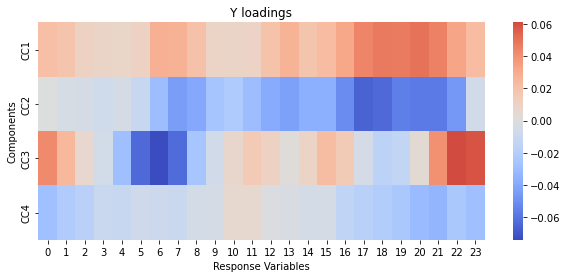

In [13]:
# plot the y loadings
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(df_y_loading.T, cmap='coolwarm', annot=False, fmt='.2f', center=0, ax=ax)
plt.title('Y loadings')
plt.ylabel('Components')
plt.xlabel('Response Variables')
plt.show()

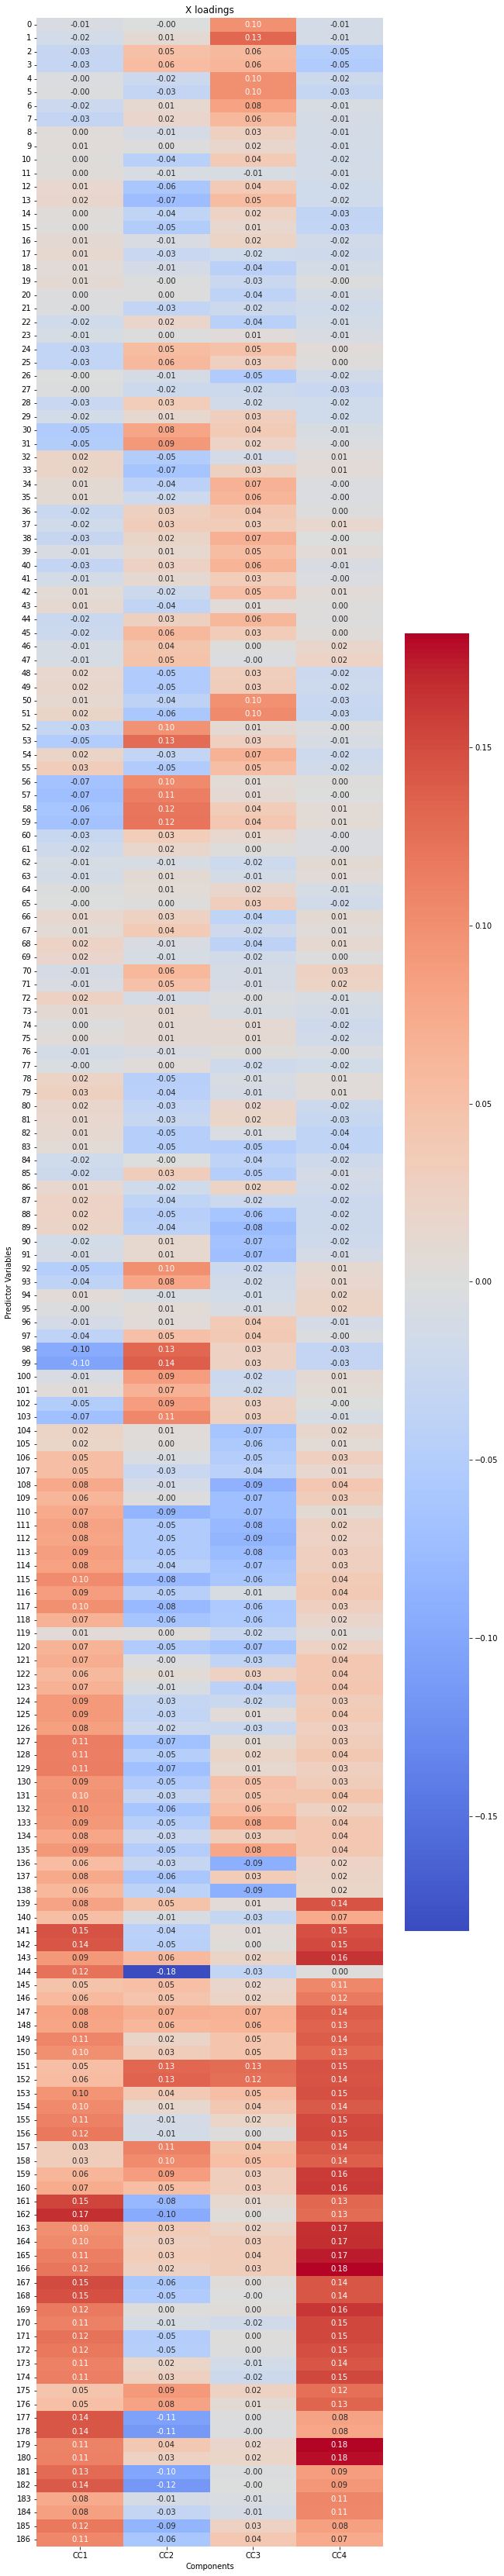

In [11]:
fig, ax = plt.subplots(figsize=(10, 60))
sns.heatmap(df_x_loading.iloc[:187,:], cmap='coolwarm', annot=True, fmt='.2f', center=0, ax=ax)
plt.title('X loadings')
plt.xlabel('Components')
plt.ylabel('Predictor Variables')
plt.show()

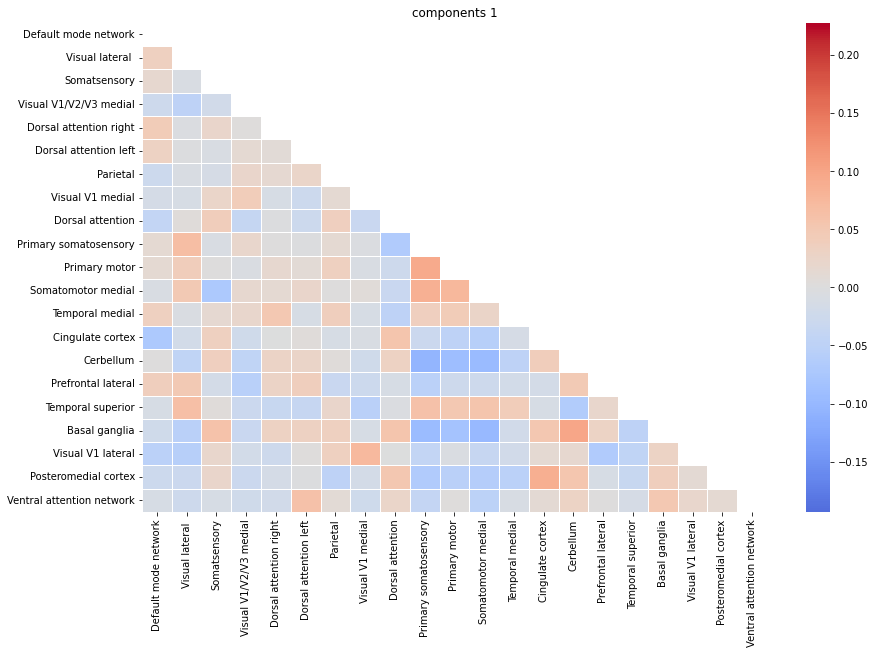

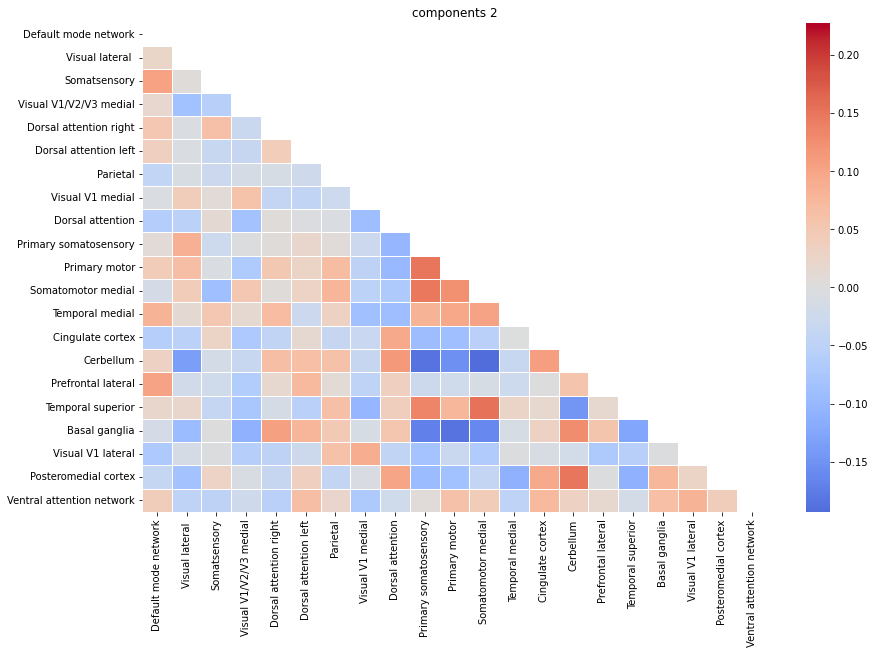

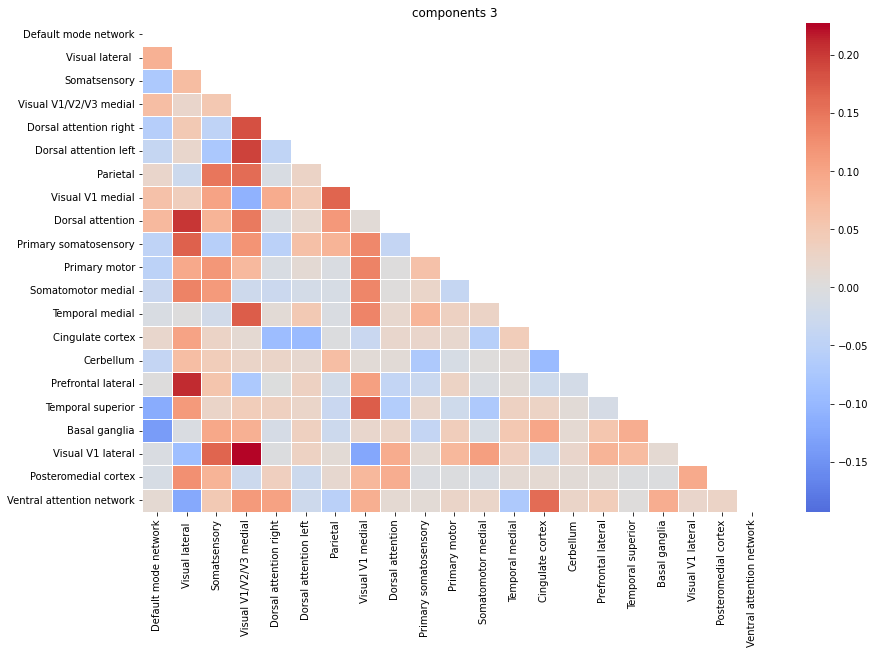

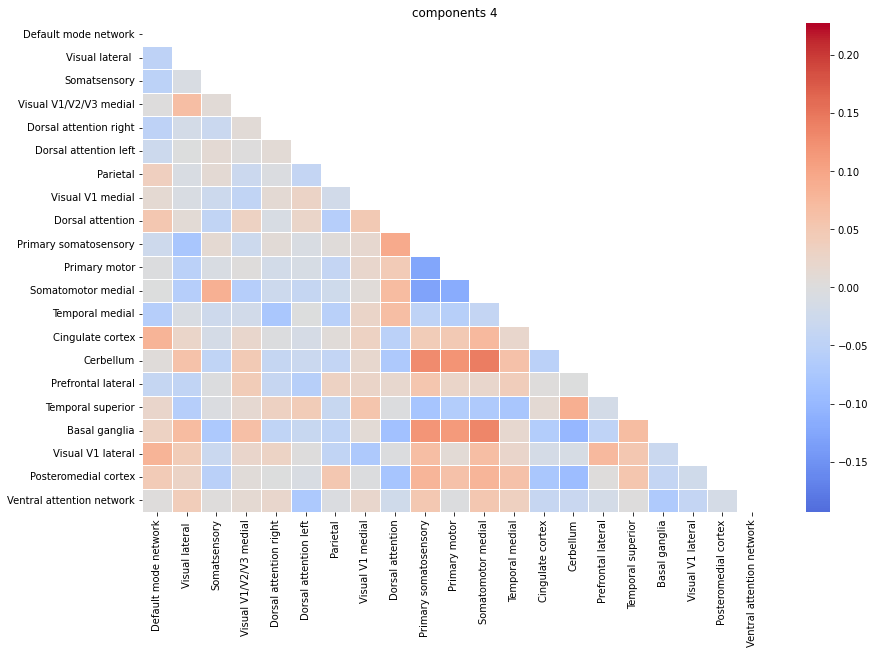

In [14]:
coef_mean = df_x_loading.iloc[187:,:]

# Set a common color scale range for all plots
vmin_value = coef_mean.min().min()
vmax_value = coef_mean.max().max()

import seaborn as sns

for i in range(len(coef_mean.columns)):
    Matrix_coef = np.zeros((21,21))
    Matrix_coef[np.tril_indices(21,k=0)] = 1
    Matrix_coef[np.tril_indices(21,k=-1)] = coef_mean.iloc[:,i]
    df_matrix = pd.DataFrame(Matrix_coef, columns=good_comps, index=good_comps)

    mask = np.triu(np.ones_like(Matrix_coef, dtype=bool))
    fig, ax = plt.subplots(figsize=(14, 9))
    sns.heatmap(df_matrix, mask=mask, center=0, cmap='coolwarm',annot=False, fmt=".2f", 
                linewidth=0.5, vmin=vmin_value, vmax=vmax_value)
    title = 'components ' + str(i+1)
    ax.set_title(title)